# **08. Introduction to Python for ML Classification and Clustering**

Welcome to our <font color=#f2cc38>**Eighth and Last Content Block**</font> in the Python Course! 

After having dealt with different content blocks throughout the weeks, together with the last module, we will put the cherry on top to our Python training by means of introducing some Machine Learning fundamentals in Python. Throughout this introduction, our library of reference will mostly be **sci-kit learn**, which counts on a set of inherent models, functionalities for data engineering, error metrics, etc., worth checking. TOday, we will take a closer look at sci-kit learn for **Classification and Clustering**.

Throughout this class, take a look at:

- Classification Problem
    - Import and explore a reference dataset
    - Do some Feature Engineering:
        - Prepare our transformation pipeline
        - Dealing with nulls, irrelevant data, data quality issues and the like
        - Take care of Categorical variables via Ordinal Encoding
        - Feature Scaling
    - Train a Logistic Regression model
    - Evaluate it with the Confusion Matrix and the Classification Report
    - Iterate to get better results:
        - Explore OHE for categorical variables
        - Train other models: XGB for classification
- Clustering problem:
    - Import and explore a reference dataset
    - Do some Feature Engineering
    - Explore the Elbow method to decide upon the number of clusters to use
    - Explore thhe Silhouette Diagram to decide upon the number of clusters to use
    - Fit a k-means model
    - Interpret the variable characteristics found for each cluster

## **1. Classification Problem**

We will import a really classic dataset for classification among the DS community: the **titanic dataset**.

It basically considers several passengers present during the titanic crash, several of their attributes (like sex, fare, etc.), and whether they survived or not. It can be used to **predict whether a passenger survived the titanic crash**, which is a classic problem of classification.

Let's first import the dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
df = pd.read_csv('data/train_titanic.csv')

### **Dataset Exploration**

The different columns we have consider:
- The Passenger ID
- Whether he survived or not
- The Passenger class
- His/her name
- Age
- SibSp: a way to define family relations (sibling, spouse) with which they travelled
- Parch: a way to deifne the number of parents/children with which they travelled
- The ticket number
- The passenger fare
- Cabin number
- Port of embarkation: three categories


In [11]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [33]:
df[['Pclass', 'Survived']].value_counts().sort_values()

Pclass  Survived
1       0            80
2       1            87
        0            97
3       1           119
1       1           136
3       0           372
dtype: int64

<AxesSubplot:>

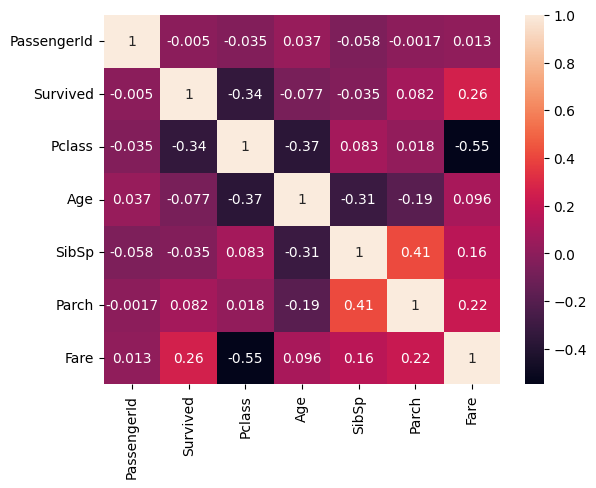

In [7]:
sns.heatmap(df.corr(numeric_only = True), annot = True)

After taking a look at the data we can see several things:
    
- There are a series of variables that give information we may omit:
    - PassengerID
    - Name
    - Ticket
- The cabin field could be subject to some feature extraction process, as the first letter of the fields may signify something.
- However, the cabin field has too high a number of nulls, therefore we can just drop the column.
- We need to fill null values for the age class.
- We need to do that as well with the Embarked one.
- The PClass is a categorical field that is encoded as a numerical one. In fact, passengers in the 3rd class, are three times as valuable as passengers in the first.
- Some categories are imbalanced, such as for instance Pclass. We should take care of checking that while splitting.
- The Sibsp and Parch variables correlate somehow. Maybe we could explore dropping one of them, and see results.
- Sex and Embarked relate to a string category, and we should transform them.
- Age doesn't seem to correlate much with whether the passenger survived or not.

Having seen that, let's proceed to cover all necessary calculations.

### **Feature Engineering**

In [34]:
df1 = df.copy()

#### **Let's drop all unnecessary variables**

In [35]:
df1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [36]:
df1.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

#### **Create the pipeline for the transformations**

In the pipeline, we have to enact different transformations:
1. Correct the NaN values in Age
2. Encode Categorical Variables
3. Scale Features

As for Encoding, we will use first **Ordinal Encoding**, and in a later iteration, **One Hot Encoding**, to see its different results.

When building the **Pipeline object**, this time we will need our columns to follow very different treatments **depending on whether they are categorical or numerical variables**.

For that, we need to use another sklearn's object: **Column Transformer**. That way, we can treat with two different pipelines the information according to whether it's categorical or not.

Let's see:

In [79]:
from sklearn.compose import ColumnTransformer # applies transformers to specific columns at a time
from sklearn.impute import SimpleImputer # this is a sklearn object to simply fill null values
from sklearn.preprocessing import StandardScaler # For Feature Scaling
from sklearn.preprocessing import OrdinalEncoder # Ordinal Encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder # One ot Encoding, for later
from sklearn.pipeline import make_pipeline # to create pipelines, slightly different to our Pipeline object of last week!
from sklearn.model_selection import train_test_split # To split our dataset.

In [59]:
# define the pipelines

# in our numerical pipeline, we need to impute null values for Age
# plus, we need to standardize valuesdo
num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # Use SimpleImputer for filling null values with mean
    StandardScaler(),  # Apply StandardScaler to all columns
)

# in our categorical pipeline, we also need to impute values, as there are some NaNs in EMbarked
# plus, despite using categorical encoding, scaling the values will be negligible in the low amount of categories we have for each variable.
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # We impute the most frequent class
    OrdinalEncoder(),  # Apply StandardScaler to all columns
)

See how, wih the previous object **make_pipeline** instead of Pipeline, we did not need to define the name of every transformation that we wanted to make.

Now, the final step, putting it all in a same pipeline:

In [60]:
df1.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [61]:
# first, define the groups of categorical and numerical variables
cat_vars = ['Sex', 'Embarked']
num_vars = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'] # we are treating Pclass here as a numerical variable

# define our column Transformer object
preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_vars),
    ('cat', cat_pipeline, cat_vars)
])

We could also use another type of objects, **make_column_selector** and **make_column_transformer** to create the final preprocessing pipeline. They are favoured versus ColumnTransformer in the sense that they **separate automatically cat and numerical variables**. In this sense, sklearn does it for you in a sense.

However, in this particular case we will not use it because maybe we want to keep control of the process - for instance, if Pclass is a categorical variable that we later want to OHE, maybe we want to retain control of what are categorical variables and what not, and not have sklearn do it for us based on the dtype of the column.

### **Fitting the Pipeline and Splitting the Dataset**

Let's continue: now we are just missing one step: to **fit and transform** our pipeline. However, remember that first we need to **split our dataset** to be sure to keep our train and test datasets independent from each other!

In [62]:
# Indicate X and y
X = df1.drop('Survived', axis = 1)
y = df1['Survived']

# split our dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# fit_transform
X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)

### **Training and Evaluating our Model**

Let's first try with two relatively simple models: a simple Logistic Regression, and a Stochastic Gradient Descent (SGD) Classifier model. 

In [65]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [66]:
# create models
lr_clf = LogisticRegression(random_state = 42)
sgd_clf = SGDClassifier(random_state = 42)

# train models
lr_clf.fit(X_train, y_train)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

Now, let's evaluate our models

In [68]:
# make predictions
y_pred_1 = lr_clf.predict(X_test)
y_pred_2 = sgd_clf.predict(X_test)

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

First, for **logistic regression**

In [71]:
confusion_matrix(y_test, y_pred_1)

array([[67, 11],
       [14, 42]])

In [73]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        78
           1       0.79      0.75      0.77        56

    accuracy                           0.81       134
   macro avg       0.81      0.80      0.81       134
weighted avg       0.81      0.81      0.81       134



Now, for **SGD**

In [77]:
confusion_matrix(y_test, y_pred_2)

array([[66, 12],
       [20, 36]])

In [78]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.77      0.85      0.80        78
           1       0.75      0.64      0.69        56

    accuracy                           0.76       134
   macro avg       0.76      0.74      0.75       134
weighted avg       0.76      0.76      0.76       134



Logistic Regression has seemed to perform better for this dataset as such.

### **Iterating to get better results**

This time, we will use:

- OHE
- Also, a higher complexity model, RandomForest

First, redefine the pipeline

In [81]:
# define the groups of categorical and numerical variables
cat_vars = ['Sex', 'Embarked', 'Pclass'] # this time, we are including PClass in this group
num_vars = ['Age', 'SibSp', 'Parch', 'Fare'] # we are treating Pclass here as a numerical variable

In [105]:
# define the pipelines

# in our numerical pipeline, we need to impute null values for Age
# plus, we need to standardize valuesdo
num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # Use SimpleImputer for filling null values with mean
    StandardScaler(),  # Apply StandardScaler to all columns
)

# in our categorical pipeline, we also need to impute values, as there are some NaNs in EMbarked
# plus, despite using categorical encoding, scaling the values will be negligible in the low amount of categories we have for each variable.
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # We impute the most frequent class
    OneHotEncoder(handle_unknown = 'ignore'),  # Apply StandardScaler to all columns
)

# define our column Transformer object
preprocessing_with_scaling = ColumnTransformer([
    ('num', num_pipeline, num_vars),
    ('cat', cat_pipeline, cat_vars)
])

Also, as Scaling is not necessary for tree-based methods like RandomForest, we'll create another separate pipeline

In [106]:
# define the pipelines

# in our numerical pipeline, we need to impute null values for Age
# plus, we need to standardize valuesdo
num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean')  # Use SimpleImputer for filling null values with mean
)

# in our categorical pipeline, we also need to impute values, as there are some NaNs in EMbarked
# plus, despite using categorical encoding, scaling the values will be negligible in the low amount of categories we have for each variable.
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # We impute the most frequent class
    OneHotEncoder(handle_unknown = 'ignore'),  # Apply StandardScaler to all columns
)

# define our column Transformer object
preprocessing_without_scaling = ColumnTransformer([
    ('num', num_pipeline, num_vars),
    ('cat', cat_pipeline, cat_vars)
])

Fit the new models

In [107]:
# split our dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [109]:
# fit_transform
X_train_1 = preprocessing_with_scaling.fit_transform(X_train)
X_test_1 = preprocessing_with_scaling.transform(X_test)

# fit_transform
X_train_2 = preprocessing_without_scaling.fit_transform(X_train)
X_test_2 = preprocessing_without_scaling.transform(X_test)

Train models and predict

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [112]:
# create models
lr_clf = LogisticRegression(random_state = 42)
rf_clf = RandomForestClassifier(random_state = 42)

# train models
lr_clf.fit(X_train_1, y_train)
rf_clf.fit(X_train_2, y_train)

# make predictions
y_pred_1 = lr_clf.predict(X_test_1)
y_pred_2 = rf_clf.predict(X_test_2)

Evaluate for the **linear regressor**

In [113]:
confusion_matrix(y_test, y_pred_1)

array([[67, 11],
       [14, 42]])

In [114]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        78
           1       0.79      0.75      0.77        56

    accuracy                           0.81       134
   macro avg       0.81      0.80      0.81       134
weighted avg       0.81      0.81      0.81       134



Evaluate for the **RandomForest Classifier**

In [115]:
confusion_matrix(y_test, y_pred_2)

array([[69,  9],
       [13, 43]])

In [116]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        78
           1       0.83      0.77      0.80        56

    accuracy                           0.84       134
   macro avg       0.83      0.83      0.83       134
weighted avg       0.84      0.84      0.83       134



Better performance with the model of higher complexity!

There can be several things here. OHE and Ordinal Encoding have produced the same result. it can be due to the fact that the Passenger Class itself is better coded as a numerical dimension, because of its high correlation value with survived. There's some margin of improvement with a lot of things - more accurately imputing values, exploring treating the PCLass as a numerical value as I said before, dropping potentially redundant variables or variables that may not matter that much, etc.

## **2. Clustering Problem**

Now, we're going to, very executively, go through a last ML problem of Clustering.

For that, we will import **arbitrary** data with the usage of the **make_blobs** functionality in sklearn.

In [117]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

Make blobs is a super useful tool in sklearn to experiment and practice with Clustering. It lets you create random data, as Gaussian blobs, for clustering. More about it here: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html.

We will use it in a really basic way, just with two dimensions, to get a visual idea of what clustering means.

Of course, normally your business problems will not be as simple, and you will need to choose which dimensions to choose, whether to use **PCA** techniques and the like, so as to be able to solve a real life clustering exercise.

Let's see about it:

In [145]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)

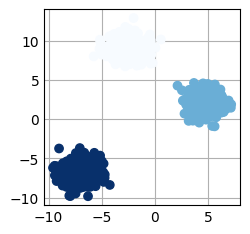

In [146]:
plt.style.use('_mpl-gallery')
# plot
fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], c = y)

plt.show()

However, as you can see, this can be really artificial. However, increasing the number of clusters can get to complicate things:

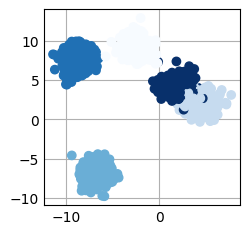

In [147]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=42)

plt.style.use('_mpl-gallery')
# plot
fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], c = y)

plt.show()

These clusters are already more mixed!

### **An example of clustering. Defining X with the Elbow Method**

Let's set a fixed number of clusters ourselves, that lead to greater complication: let's create 8 clusters, and visualize them:

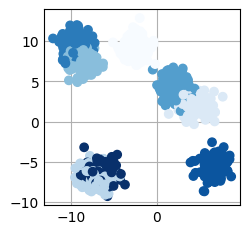

In [151]:
X, y = make_blobs(n_samples=1000, centers=8, n_features=2, random_state=42)

plt.style.use('_mpl-gallery')
# plot
fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], c = y)

plt.show()

We can see how several of them are quite mingled! They could be treated even as the same cluster!

Now, let's fit a k-means model. That is actually quite simple, you hould just do:

In [152]:
# define a k
k = 8

# fit the model 
kmeans = KMeans(n_clusters = k, random_state = 42)
y_pred = kmeans.fit_predict(X)

# and we have finished our problem! We just need to interpret the results and that's it!

Remember, we do not evaluate the result with y, because we normally do not have it. Remember, this is an **unsupervised** technique, which accuracy, f1-score, auc, etc., is not being tested!

For new incoming datapoints you can use (after fitting) kmeans.predict(X_new) to find out the cluster to which every new instance would belong to.

The difficult part, though, is finding the **appropiate number of clusters** (apart from, in real datasets, doing all the process of Feature Selection and Transformation).

Let's find them first with the **Elbow** method.

In [160]:
kmeans.inertia_ # this is the variable that we need to plot, for several k

1701.3782859100809

In [166]:
def retrieve_inertia(X, num_of_ks = 10):
    inertias = []
    for i in range(num_of_ks):
        # declare k - at least 1 cluster though!
        k = i+1
        # fit the model
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit(X)
        # retrieve inertia
        inertias.append((k, kmeans.inertia_))
    return inertias

In [167]:
inertias = retrieve_inertia(X, num_of_ks = 15)

<AxesSubplot:xlabel='k', ylabel='inertia'>

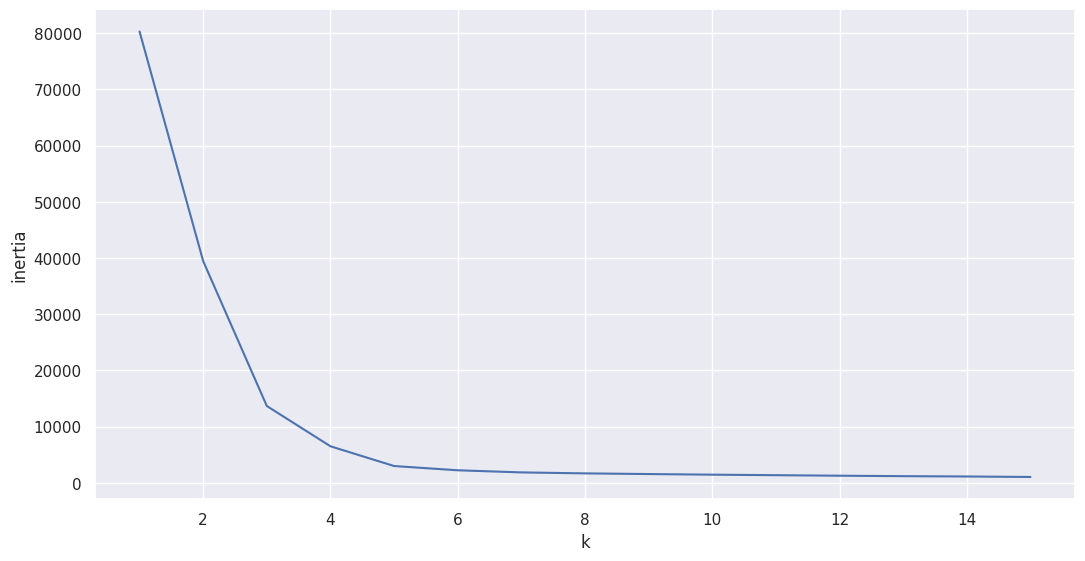

In [185]:
dfinertias = pd.DataFrame(inertias, columns = ['k', 'inertia'])
sns.set(rc={'figure.figsize':(10,5)})
sns.lineplot(data = dfinertias, x = 'k', y = 'inertia')

It seems that the optimal amount of clusters would be around **4 clusters** and not 8, as make blobs intended. e could think that, after having looked at the cluster representation above.

However, you can clearly see that no clear conclusions can be obtained out of this, as defining the number of clusters is indeed really qualitative.

Let's look further into the **silhouette score** method.

### **The Silhouette Score Method and the Silhouette Diagram**

For the silhouette diagram, we would also need to create our own ad-hoc visualization.

I have found a particular python library online that would do it for us instead.

In [186]:
!pip install yellowbrick --q

In [187]:
from yellowbrick.cluster import SilhouetteVisualizer

Let's create a function to directly plot the graphs.

In [195]:
def plot_silhouette_graphs(X, ks = [1, 2, 3]):
    for k in ks:
        visualizer = SilhouetteVisualizer(KMeans(k, random_state=42), colors='yellowbrick')
        visualizer.fit(X) 
        visualizer.show()

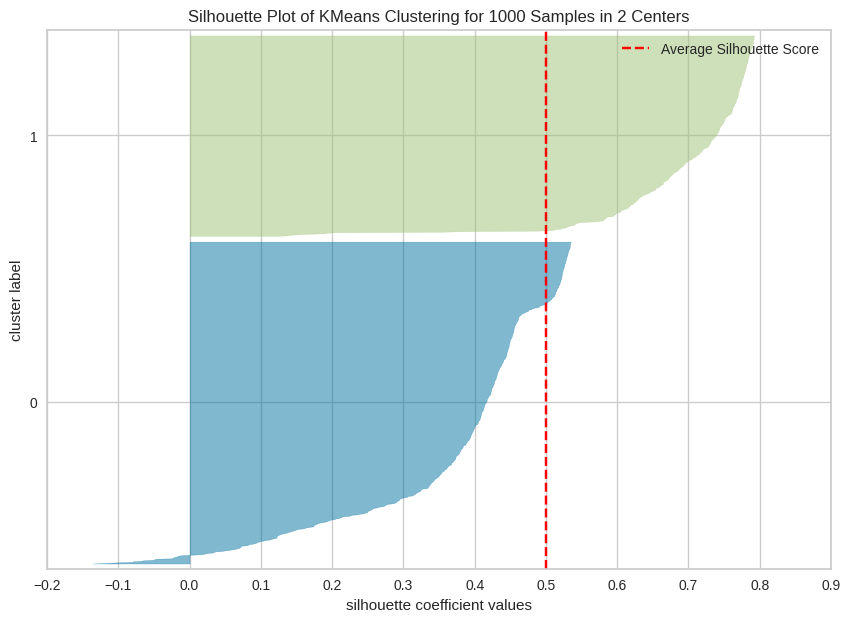

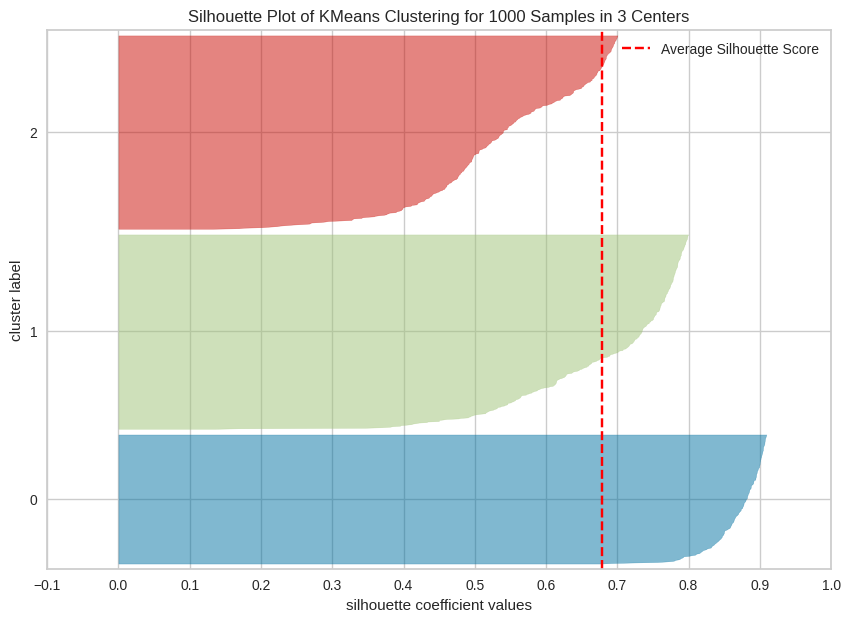

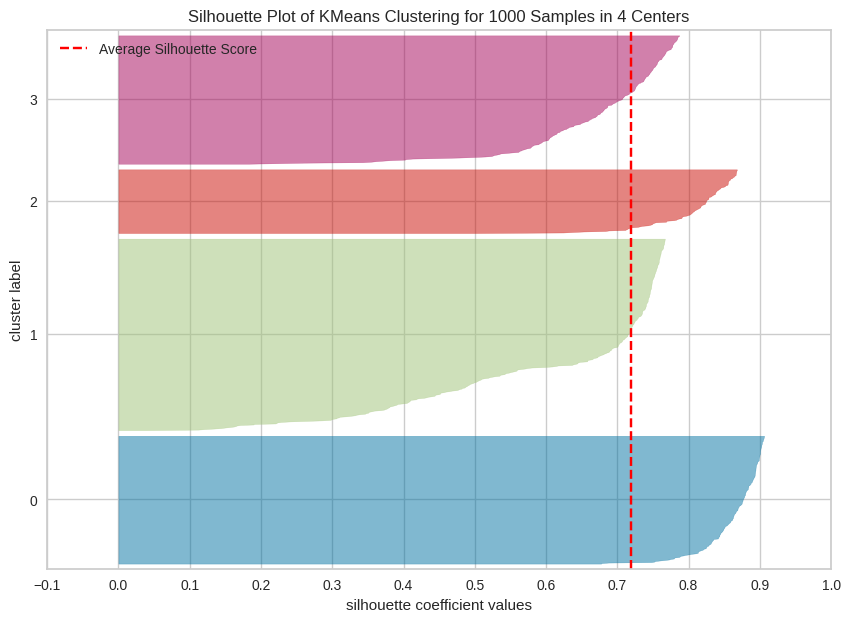

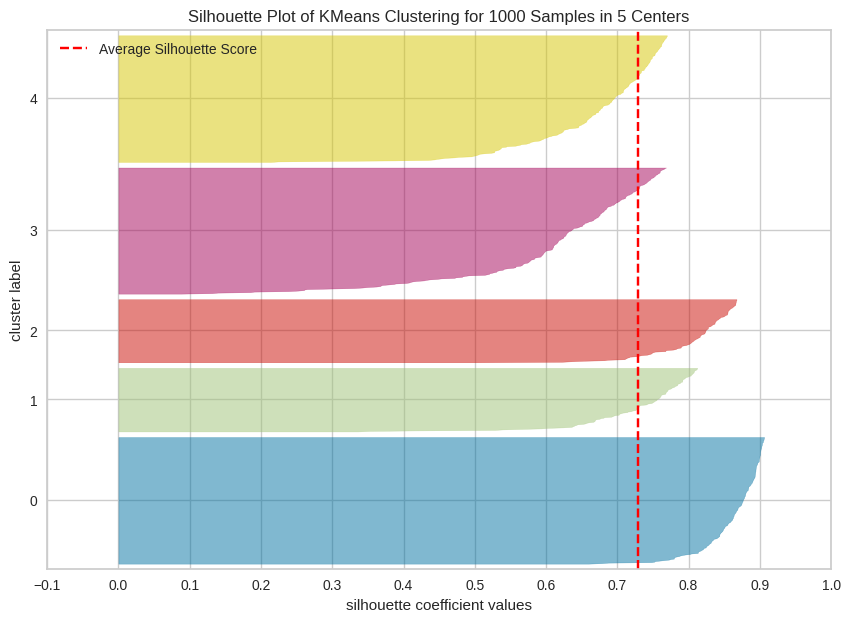

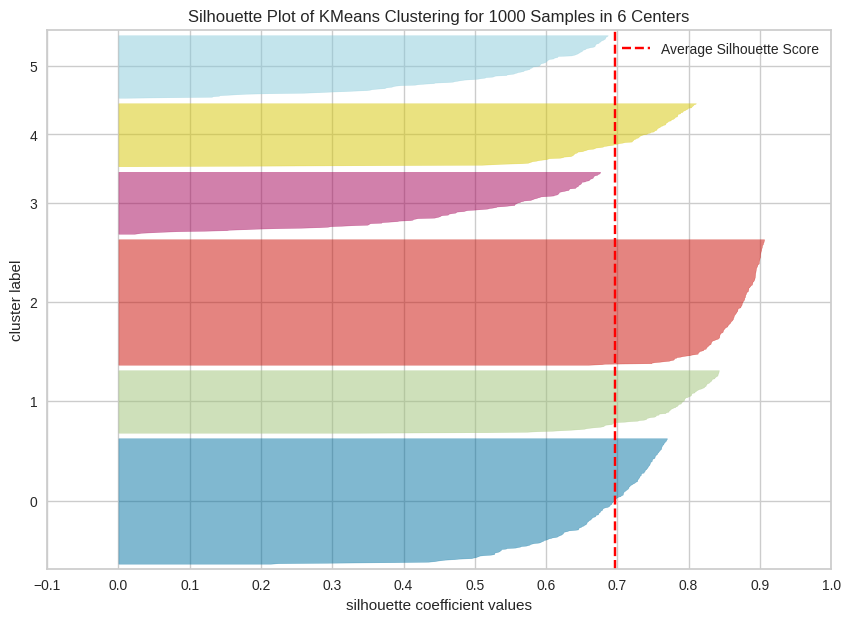

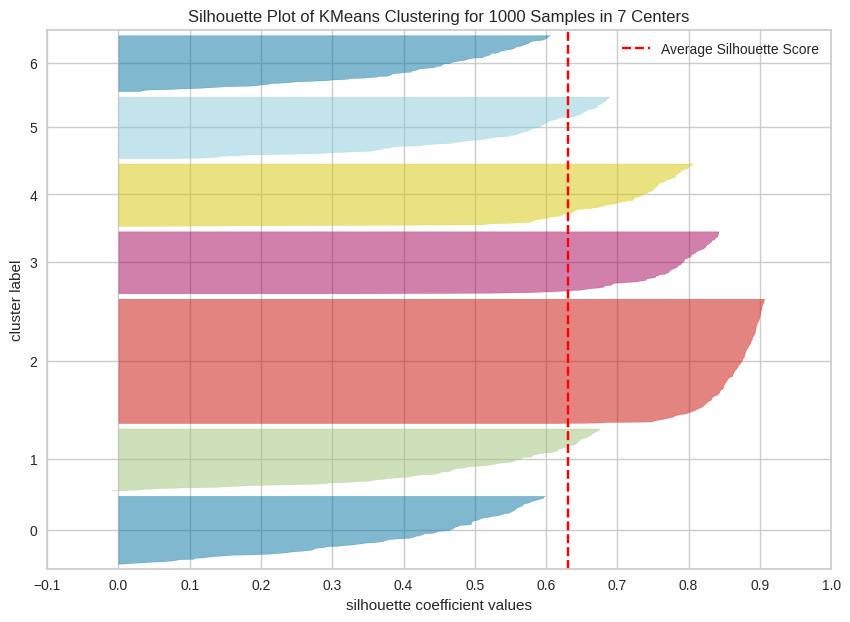

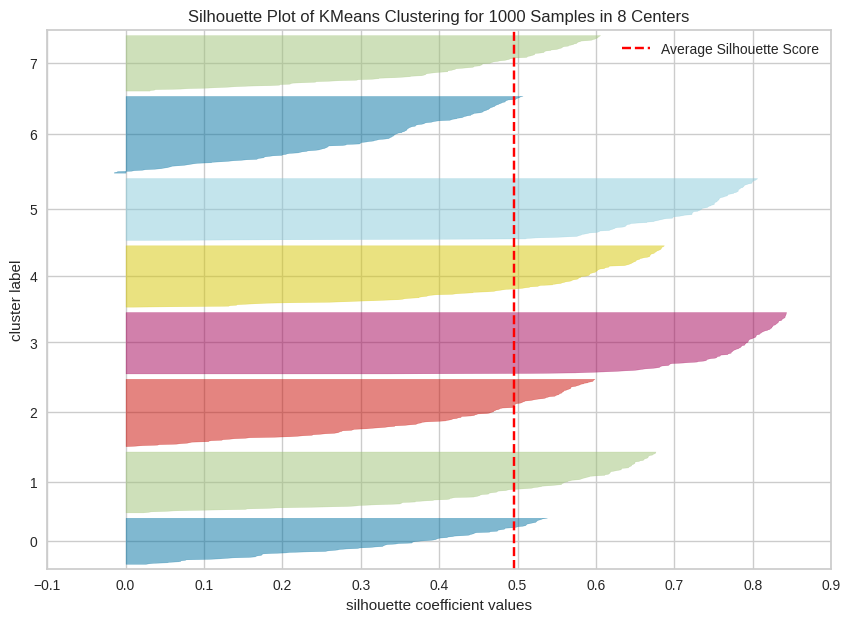

In [198]:
plot_silhouette_graphs(X, ks = [2, 3, 4, 5, 6, 7, 8])

As we can see, from 6 above it's too much. As you can see, the silhouette score **keeps decreasing**, plus there are some of the clusters with values below tat line, meaning that they are actually closer to other clusters' centroids.

2 and 3 are no valid either, because the silhouette score is also low, plus there are several clusters with too many elements with a score closer to other centroids, and too many elements overall. **4 and 5** are both good alternatives. What I would say is that 5 has a slightly greater silhouette score, thouh not much, but most of all, with this same score, manages to get many instances not close to toher centroids. The belly of **k=4 cluster 1** is, without a doubt, slightly more problematic.

### **Explaining the k-means clustering results**

Now that we have uncovered the optimal number of ks, let's fit a model.

In [204]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

Great, now what do we do with this?

Basically, we can obviously use the model to **predict new** incoming values. However, many times it makes also sense to **try to explain those clusters** that we have found.

For that, what we will want is to **retrieve the cluster centrers**, which basically returns the coordinates in each of the inputted variables for each of the centroids. When having non-dummy data, this will help us find out if a potential cluster is characterized by presenting high number of orders and average value of purchase, old male consumers, or people in the Boston Area.

In the end, a 2-D representation makes the plot clear to see, but when we have several additional variables, plots get too complicated too understand, and many times, trying to explain the behaviour of our clusters with words, is the best choice.

In [205]:
kmeans.cluster_centers_

array([[-6.73234238, -6.59464421],
       [-2.58425835,  9.06484087],
       [ 6.67756476, -5.62619086],
       [ 3.45166176,  3.04567843],
       [-9.06650961,  8.4746825 ]])